In [8]:
import xml.etree.ElementTree as ET
from tqdm import tqdm
from pathlib import Path
from tqdm import tqdm
import glob

In [9]:
train_class_names = ['pottedplant', 'sofa', 'tvmonitor', 'car', 'bottle', 'boat', 'chair', 'person', 'bus', 'train', 'horse', 'bicycle', 'dog', 'bird', 'motorbike', 'diningtable']
test_class_names = ['cow', 'sheep', 'cat', 'aeroplane']

In [10]:
import os

paths = ['images',
         'images/train',
         'images/valid',
         'images/test',
         'labels',
         'labels/train',
         'labels/valid',
         'labels/test',
         'supports']

for path in paths:
    if not os.path.exists(path):
        os.mkdir(path)

for i in range(20):
    if not os.path.exists('supports/'+str(i)):
        os.mkdir('supports/'+str(i))    

path = 'VOC'
train = [ # train images (relative to 'path')  16551 images
  'images/train2012',
  'images/train2007',
  'images/val2012',
  'images/val2007'
]
val = [ # val images (relative to 'path')  4952 images
  'images/test2007'
]
test = [ # test images (optional)
  'images/test2007'
]

In [ ]:
!wget Downloading https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtrainval_06-Nov-2007.zip -o 'VOCtrainval_06-Nov-2007.zip' # 446MB, 5012 images
!wget Downloading https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtest_06-Nov-2007.zip -o 'VOCtest_06-Nov-2007.zip' # 438MB, 4953 images
!wget Downloading https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtrainval_11-May-2012.zip -o 'VOCtrainval_11-May-2012.zip' # 1.95GB, 17126 images

In [ ]:
!unzip 'VOCtrainval_06-Nov-2007.zip.1'
!unzip 'VOCtest_06-Nov-2007.zip.1'
!unzip 'VOCtrainval_11-May-2012.zip.1'

In [ ]:
!rm 'VOCtrainval_06-Nov-2007.zip.1'
!rm 'VOCtest_06-Nov-2007.zip.1'
!rm 'VOCtrainval_11-May-2012.zip.1'

In [11]:
# Classes


def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x, y, w, h = (box[0] + box[1]) / 2.0 - 1, (box[2] + box[3]) / 2.0 - 1, box[1] - box[0], box[3] - box[2]
    return x * dw, y * dh, w * dw, h * dh

names = {
    0: 'aeroplane',
    1: 'bicycle',
    2: 'bird',
    3: 'boat',
    4: 'bottle',
    5: 'bus',
    6: 'car',
    7: 'cat',
    8: 'chair',
    9: 'cow',
    10: 'diningtable',
    11: 'dog',
    12: 'horse',
    13: 'motorbike',
    14: 'person',
    15: 'pottedplant',
    16: 'sheep',
    17: 'sofa',
    18: 'train',
    19: 'tvmonitor',
}

novel = [9, 16, 7, 0]

from PIL import Image, ImageOps

def resize_with_padding(img, expected_size):
    width, height = img.size
    ratio = width / height
    if width < height:
        img = img.resize((int(ratio*expected_size[0]),int(expected_size[0])))
    else:
        img = img.resize((int(expected_size[1]),int((1/ratio)*expected_size[1])))
        
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

support_imgs = {i:0 for i in range(20)}

def resize_label_with_padding(old_size, expected_size, bbox):
    (x,y,w,h) = bbox

    ratio = old_size[0] / old_size[1]
    if old_size[0] < old_size[1]:
        new = (int(ratio*expected_size[0]),int(expected_size[0]))
    else:
        new = (int(expected_size[1]),int((1/ratio)*expected_size[1]))

    delta_width = expected_size[0] - new[0]
    delta_height = expected_size[1] - new[1]

    pad_width = delta_width // 2
    pad_height = delta_height // 2

    x_t = (pad_width +  (x)*new[0]) / expected_size[0]
    y_t = (pad_height + (y)*new[1]) / expected_size[1]
    w_t = w*new[0] / expected_size[0]
    h_t = h*new[1] / expected_size[1]
    
    return x_t,y_t,w_t,h_t

def convert_label(image, path, lb_path, year, image_id, classes):
    in_file = open(path / f'VOC{year}/Annotations/{image_id}.xml')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    name = list(names.values())  # names list
    good = False
    for obj in root.iter('object'):
        cls = obj.find('name').text
        cls_id = name.index(cls)  # class id
        if cls_id in classes and cls in name:# and int(obj.find('difficult').text) != 1: #OK ??
            xmlbox = obj.find('bndbox')
            x1, x2, y1, y2 = [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')]
            img = image.crop((x1,y1,x2,y2))
            img = resize_with_padding(img, (160,160))
            img.save('supports/'+str(cls_id)+'/'+str(support_imgs[cls_id])+'.png')
            support_imgs[cls_id] = support_imgs[cls_id] + 1
            bb = convert_box((w, h), [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')])
            bb = resize_label_with_padding((w,h), (640,640), bb)
            with open(lb_path, 'a') as file:
                file.write(" ".join(str(a) for a in (cls_id, *bb)) + '\n')
            good = True
    return good

In [12]:
# Convert
path = Path('VOCdevkit')

for year, image_set in ('2012', 'train'), ('2012', 'val'), ('2007', 'train'), ('2007', 'val'), ('2007', 'test'):
    imgs_path = Path('images')
    lbs_path = Path('labels')

    with open(path / f'VOC{year}/ImageSets/Main/{image_set}.txt') as f:
        image_ids = f.read().strip().split()

    for id in tqdm(image_ids, desc=f'{image_set}{year}'):
        
        f = path / f'VOC{year}/JPEGImages/{id}.jpg'  # old img path
        img = Image.open(f)

        if image_set == 'train':
            img_path = (imgs_path / 'train' / f.name).with_suffix('.png')
            lb_path = (lbs_path / 'train' / f.name).with_suffix('.txt')
        if image_set == 'val':
            img_path = (imgs_path / 'valid' / f.name).with_suffix('.png')
            lb_path = (lbs_path / 'valid' / f.name).with_suffix('.txt')   
        if image_set == 'test':
            img_path = (imgs_path / 'test' / f.name).with_suffix('.png')
            lb_path = (lbs_path / 'test' / f.name).with_suffix('.txt')
            

        classes = [i for i in range(20) if i not in [9, 16, 7, 0]] if image_set == 'train' or image_set == 'val' else [9, 16, 7, 0]

        good = convert_label(img, path, lb_path, year, id, classes)  # convert labels to YOLO format
        if good:
            img = resize_with_padding(img, (640,640))
            img.save(img_path)

train2012:   0%|          | 0/5717 [00:00<?, ?it/s]

(0.522, 0.5712669683257919, 0.836, 0.7533936651583711)
(0.522, 0.5621341204751131, 0.836, 0.6651053450226245)
(0.445, 0.23642533936651586, 0.262, 0.27828054298642535)
(0.445, 0.26653174490950227, 0.262, 0.24566954185520365)


train2012:   0%|          | 2/5717 [00:00<21:31,  4.42it/s]

(0.646, 0.26758409785932724, 0.216, 0.5351681957186545)
(0.646, 0.3482033639143731, 0.21600000000000003, 0.3495317278287462)
(0.219, 0.22782874617737003, 0.214, 0.45565749235474007)
(0.219, 0.3222381498470948, 0.21400000000000002, 0.2976012996941896)


train2012:   0%|          | 3/5717 [00:00<17:56,  5.31it/s]

(0.5302083333333333, 0.36213235294117646, 0.48541666666666666, 0.7169117647058824)
(0.5302083333333333, 0.4220186121323529, 0.4854166666666667, 0.40550321691176466)
(0.5010416666666666, 0.5514705882352942, 0.31875, 0.625)
(0.5010416666666666, 0.5291130514705882, 0.31875, 0.353515625)
(0.8739583333333333, 0.20404411764705882, 0.24791666666666667, 0.40808823529411764)
(0.8739583333333332, 0.3325999540441177, 0.2479166666666667, 0.23082490808823528)
(0.4774774774774775, 0.261, 0.924924924924925, 0.522)
(0.48500844594594594, 0.261, 0.6156531531531532, 0.522)
(0.23873873873873874, 0.506, 0.24324324324324323, 0.628)
(0.326097972972973, 0.506, 0.16190878378378376, 0.628)
(0.45645645645645644, 0.14300000000000002, 0.0960960960960961, 0.146)
(0.4710163288288288, 0.14300000000000002, 0.06396396396396396, 0.146)
(0.5915915915915916, 0.138, 0.10810810810810811, 0.136)
(0.560965653153153, 0.138, 0.07195945945945946, 0.136)
(0.3258258258258258, 0.14, 0.08108108108108109, 0.128)
(0.3840653153153153, 

train2012:   0%|          | 5/5717 [00:00<16:48,  5.66it/s]

(0.387, 0.5826666666666667, 0.146, 0.10933333333333332)
(0.387, 0.562, 0.146, 0.08199999999999999)
(0.139, 0.584, 0.094, 0.096)
(0.139, 0.563, 0.094, 0.072)
(0.321, 0.04533333333333333, 0.166, 0.09066666666666666)
(0.321, 0.15899999999999997, 0.166, 0.06799999999999999)
(0.388, 0.20933333333333332, 0.312, 0.22133333333333333)
(0.388, 0.282, 0.312, 0.16599999999999998)
(0.599, 0.412, 0.378, 0.43466666666666665)
(0.599, 0.434, 0.378, 0.32599999999999996)
(0.522, 0.25066666666666665, 0.9520000000000001, 0.496)
(0.522, 0.313, 0.9520000000000002, 0.372)
(0.499, 0.6226666666666666, 0.998, 0.2533333333333333)
(0.499, 0.5919999999999999, 0.998, 0.18999999999999997)


train2012:   0%|          | 7/5717 [00:01<12:27,  7.64it/s]

(0.655, 0.536, 0.23, 0.17066666666666666)
(0.655, 0.527, 0.23000000000000004, 0.128)
(0.621, 0.5573333333333333, 0.066, 0.112)
(0.621, 0.5429999999999999, 0.066, 0.08399999999999999)
(0.46, 0.5466666666666666, 0.1, 0.16)
(0.4600000000000001, 0.5349999999999999, 0.1, 0.12)
(0.318, 0.6533333333333333, 0.152, 0.448)
(0.318, 0.615, 0.152, 0.33599999999999997)
(0.9550000000000001, 0.6759999999999999, 0.08600000000000001, 0.22666666666666666)
(0.9550000000000001, 0.6319999999999999, 0.08600000000000001, 0.16999999999999998)
(0.936, 0.5519999999999999, 0.124, 0.18666666666666665)
(0.9360000000000002, 0.5389999999999999, 0.124, 0.13999999999999999)
(0.801, 0.86, 0.202, 0.27466666666666667)
(0.8009999999999999, 0.77, 0.202, 0.20600000000000002)
(0.616, 0.816, 0.176, 0.304)
(0.616, 0.7369999999999999, 0.176, 0.22799999999999998)
(0.47300000000000003, 0.844, 0.194, 0.30666666666666664)
(0.47300000000000003, 0.758, 0.194, 0.22999999999999998)
(0.549, 0.7373333333333333, 0.506, 0.2853333333333333)


train2012:   0%|          | 9/5717 [00:01<16:02,  5.93it/s]


(0.498, 0.5093333333333333, 0.8200000000000001, 0.7999999999999999)
(0.49800000000000005, 0.507, 0.8200000000000001, 0.5999999999999999)


KeyboardInterrupt: 

In [6]:
with open('data.yaml', 'wt') as f:
    f.write('train: images/train \n')
    f.write('val: images/valid \n')
    f.write('test: images/test \n')
    f.write('dairy: images/dairy \n')
    f.write('paste: images/paste \n')
    f.write('support: supports \n')
    f.write(' \n')
    f.write('nc: '+str(20)+'\n')

100%|██████████| 6993/6993 [00:00<00:00, 24396.06it/s]


20


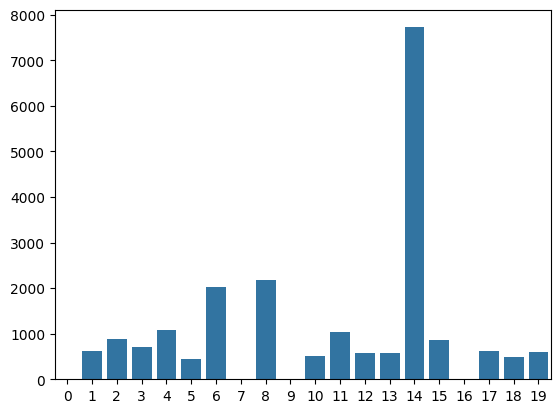

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

a = []

lbs_path = 'labels/train/*'

for i in tqdm(glob.glob(str(lbs_path))):
    with open(i,'+r') as f:
        info = f.read().strip().split()
        size = len(info)
        for y in range(0,size,5):
            inf = info[y:y+5]
            a.append(inf[0])   

count = {i:a.count(str(i)) for i in range(0,20)}
print(len(count))

plt.figure()
sns.barplot(x=range(0,20),y=count.values())
plt.show()

In [ ]:
!rm -rf VOCdevkit